# Covid vaccination dataset with cities population information
### Data Engineering Capstone Project

#### Project Summary
Enrich a Brazilian Covid Vaccine dataset with information about the different population count for each Brazilian city (considering sex and color) using PySpark and Pandas. By doing this, it's possible to make an analysis to check which kind of vaccine were more applied in each type of population for each city and audit government behavior based on this.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, unix_timestamp, from_unixtime, udf, sum as _sum, dayofmonth, dayofweek, month, year, weekofyear, split, lit, col
from pyspark.sql.types import DateType
from pyspark.sql import Window
import sys
import datetime

In [2]:
# Create Spark Session
spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
This project intend to get relations between the vaccined and cities regions in Brazil.
Three datasources will br used: 
- brazilian_vaccines_info.csv : Brazilian Vaccine information per patient
- brazilian_cities_info.csv: Brazilian population count for each city by different sex.
- brazilian_cities_color_info.csv: Brazilian population for each city by different colors.
PySpark will be used to process and handle data.

#### Describe and Gather Data 
Covid vaccine data: This dataset is from Kaggle. It's basically a csv file where we can find the data about vaccination in Brazilian people.
It can be found in: https://www.kaggle.com/guilhermegoncalves/vacinao-brasil-microdados

Brazilian cities information: In this dataset we have information about brazilian cities population by color and sex.
It can be found in: https://sidra.ibge.gov.br/tabela/2093

In [3]:
# Read in the data here
df = spark.read.format("csv").option("header", "true").load("brazilian_vaccines_info.csv")

In [4]:
df.limit(5).toPandas()

,paciente_codigo_grupo,vacina,vacina_lote,estabelecimento_razao_social,estabelecimento,paciente_cep,estabelecimento_unidade_federativa,sistema_origem,paciente_municipio,paciente_etnia,...,data_aplicacao,documento_uuid,paciente_sexo_biologico,estabelecimento_codigo_cnes,paciente_unidade_federativa,paciente_codigo_pais,paciente_pais,paciente_codigo_ibge_municipio,paciente_subgrupo,paciente_codigo_etnia
0,9,Covid-19-Coronavac-Sinovac/Butantan,202009011,PM DE MORRO DO CHAPEU DO PIAUI,UNIDADE BASICA DE SAUDE PATRIOTINO LAGES REBELO,64180,PI,ESUS APS - NACIONAL (OFFLINE),Esperantina,Amarela,...,2021-02-16,f9a282c2-d608-50e3-8cd6-614b94579138,F,2649462,PI,10,Brasil,2203701,Enfermeiro(a),4
1,9,Covid-19-Coronavac-Sinovac/Butantan,210009,SANTA CASA DE MISERICORDIA DE GUARAREMA,SANTA CASA DE GUARAREMA,12010,SP,VACIVIDA,Taubaté,Branca,...,2021-02-06,0b20fb92-d744-563c-ba0e-fa4a8839fbef,F,2773333,SP,10,Brasil,3554102,Outros,1
2,9,Covid-19-Coronavac-Sinovac/Butantan,202010041,SECRETARIA DE SAUDE,HOSPITAL BARAO DE LUCENA,50751,PE,Novo PNI,Recife,Amarela,...,2021-02-12,df60db8c-841a-572d-873b-3f45ea50306a,M,2427427,PE,10,Brasil,2611606,Auxiliar de Enfermagem,4
3,9,Covid-19-Coronavac-Sinovac/Butantan,210009,MUNICIPIO DE SAO VICENTE,ESF RIO BRANCO II E III SAO VICENTE,11349,SP,VACIVIDA,São Vicente,None,...,2021-02-08,f72b6488-50ba-5fb6-ad53-52c4563f4442,F,2033275,SP,10,Brasil,3551009,Outros,99
4,9,Vacina Covid-19 - Covishield,4120Z005,MUNICIPIO DE JOAO PESSOA,REDE FRIO CENTRAL MUNICIPAL DE IMUNOBIOLOGICOS,58020,PB,Novo PNI,João Pessoa,Amarela,...,2021-02-02,597a9698-ba66-5e11-a1b8-bbe72dabbb33,M,287660,PB,10,Brasil,2507507,Técnico de Enfermagem,4


In [5]:
df.count()

6272491

In [6]:
df_cities_by_sex = spark.read.format("csv").option("delimiter",";").option("header", "true").load("brazilian_cities_info.csv")

In [7]:
df_cities_by_sex.limit(5).toPandas()

,Brasil e Município,Situação do domicílio,Grupo de idade,Total,Homens,Mulheres
0,Brasil,Total,Total,190755799,93406990,97348809
1,Alta Floresta D'Oeste (RO),Total,Total,24392,12656,11736
2,Ariquemes (RO),Total,Total,90353,45543,44810
3,Cabixi (RO),Total,Total,6313,3266,3047
4,Cacoal (RO),Total,Total,78574,39124,39450


In [8]:
df_cities_by_color = spark.read.format("csv").option("delimiter",";").option("header", "true").load("brazilian_cities_color_info.csv")

In [9]:
df_cities_by_color.limit(5).toPandas()

,Brasil e Município,Situação do domicílio,Grupo de idade,Total,Branca,Preta,Amarela,Parda,Indígena,Sem declaração
0,Brasil,Total,Total,190755799,90621281,14351162,2105353,82820452,821501,36051
1,Alta Floresta D'Oeste (RO),Total,Total,24392,10583,1094,96,12122,497,-
2,Ariquemes (RO),Total,Total,90353,32025,7810,1916,48505,97,-
3,Cabixi (RO),Total,Total,6313,2918,465,101,2827,3,-
4,Cacoal (RO),Total,Total,78574,32837,4534,1023,38714,1467,-


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
- Perform casts in order to have the right types for each field.
- Remove null values from some important columns.
- Remove duplicated and unused data in cities related dataframes.

In [10]:
# Performing cleaning tasks here
def perform_column_cast(dataframe, col_name, new_type):
    return dataframe.withColumn(col_name, dataframe[col_name].cast(new_type))

def remove_null_rows(dataframe, col_name):
    return dataframe.filter(col(col_name).isNotNull())

#### Cleaning Vaccines Dataset

In [11]:
df.printSchema()

root
 |-- paciente_codigo_grupo: string (nullable = true)
 |-- vacina: string (nullable = true)
 |-- vacina_lote: string (nullable = true)
 |-- estabelecimento_razao_social: string (nullable = true)
 |-- estabelecimento: string (nullable = true)
 |-- paciente_cep: string (nullable = true)
 |-- estabelecimento_unidade_federativa: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- paciente_municipio: string (nullable = true)
 |-- paciente_etnia: string (nullable = true)
 |-- estabelecimento_municipio: string (nullable = true)
 |-- paciente_idade: string (nullable = true)
 |-- paciente_codigo_subgrupo: string (nullable = true)
 |-- numero_dose: string (nullable = true)
 |-- paciente_nacionalidade: string (nullable = true)
 |-- codigo_vacina: string (nullable = true)
 |-- estabelecimento_codigo_ibge_municipio: string (nullable = true)
 |-- paciente_uuid: string (nullable = true)
 |-- paciente_grupo: string (nullable = true)
 |-- data_aplicacao: string (nullable = t

In [12]:
# Count number of null values per collumns
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,paciente_codigo_grupo,vacina,vacina_lote,estabelecimento_razao_social,estabelecimento,paciente_cep,estabelecimento_unidade_federativa,sistema_origem,paciente_municipio,paciente_etnia,...,data_aplicacao,documento_uuid,paciente_sexo_biologico,estabelecimento_codigo_cnes,paciente_unidade_federativa,paciente_codigo_pais,paciente_pais,paciente_codigo_ibge_municipio,paciente_subgrupo,paciente_codigo_etnia
0,118923,0,0,0,0,1247460,0,0,34922,1673840,...,20782,0,1,0,34951,33962,33962,34951,118923,1


In [13]:
def fix_column_type_vac(df):
    #Provide the correct type for all columns
    df_cleaned_vac = df
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_codigo_grupo", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "vacina_lote", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_cep", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_codigo_subgrupo", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "numero_dose", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "codigo_vacina", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "estabelecimento_codigo_ibge_municipio", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "estabelecimento_codigo_cnes", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_codigo_pais", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_codigo_ibge_municipio", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "paciente_codigo_etnia", 'int')
    df_cleaned_vac = perform_column_cast(df_cleaned_vac, "data_aplicacao", 'date')
    return df_cleaned_vac

df_cleaned_vac = fix_column_type_vac(df)

#remove rows where we have the city as null
df_cleaned_vac = remove_null_rows(df_cleaned_vac, 'paciente_municipio') #city name
df_cleaned_vac = remove_null_rows(df_cleaned_vac, 'paciente_codigo_ibge_municipio') #city code

df_cleaned_vac.printSchema()

root
 |-- paciente_codigo_grupo: integer (nullable = true)
 |-- vacina: string (nullable = true)
 |-- vacina_lote: integer (nullable = true)
 |-- estabelecimento_razao_social: string (nullable = true)
 |-- estabelecimento: string (nullable = true)
 |-- paciente_cep: integer (nullable = true)
 |-- estabelecimento_unidade_federativa: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- paciente_municipio: string (nullable = true)
 |-- paciente_etnia: string (nullable = true)
 |-- estabelecimento_municipio: string (nullable = true)
 |-- paciente_idade: string (nullable = true)
 |-- paciente_codigo_subgrupo: integer (nullable = true)
 |-- numero_dose: integer (nullable = true)
 |-- paciente_nacionalidade: string (nullable = true)
 |-- codigo_vacina: integer (nullable = true)
 |-- estabelecimento_codigo_ibge_municipio: integer (nullable = true)
 |-- paciente_uuid: string (nullable = true)
 |-- paciente_grupo: string (nullable = true)
 |-- data_aplicacao: date (nullabl

In [14]:
# Checking how many different cities we have in the vaccine dataset
cities_number = df_cleaned_vac.select('paciente_codigo_ibge_municipio').distinct().count()
print("Numbers of cities covered in vaccine dataset: ", cities_number)

Numbers of cities covered in vaccine dataset:  5570


#### Cleaning Cities Datasets

In [15]:
def clean_cities_datasets(df_cities_by_sex, df_cities_by_color):
    #Joining cities datasets and removing duplicated or unused columns
    df_cleaned_cities = df_cities_by_sex.join(df_cities_by_color, df_cities_by_sex['Brasil e Município'] == df_cities_by_color['Brasil e Município'], "inner")\
    .drop(df_cities_by_color['Brasil e Município'])\
    .drop(df_cities_by_color['Situação do domicílio'])\
    .drop(df_cities_by_color['Grupo de idade'])\
    .drop(df_cities_by_color['Total'])\
    .drop(df_cities_by_sex['Situação do domicílio'])\
    .drop(df_cities_by_sex['Grupo de idade']) 
    return df_cleaned_cities

df_cleaned_cities = clean_cities_datasets(df_cities_by_sex, df_cities_by_color)

In [16]:
df_cleaned_cities.limit(5).toPandas()

,Brasil e Município,Total,Homens,Mulheres,Branca,Preta,Amarela,Parda,Indígena,Sem declaração
0,Brasil,190755799,93406990,97348809,90621281,14351162,2105353,82820452,821501,36051
1,Alta Floresta D'Oeste (RO),24392,12656,11736,10583,1094,96,12122,497,-
2,Ariquemes (RO),90353,45543,44810,32025,7810,1916,48505,97,-
3,Cabixi (RO),6313,3266,3047,2918,465,101,2827,3,-
4,Cacoal (RO),78574,39124,39450,32837,4534,1023,38714,1467,-


In [17]:
def split_city_state(df_cleaned_cities):
    #Separating column that contains City and State name in 2 different columns
    df_cleaned_cities = df_cleaned_cities.withColumn('City', split(df_cleaned_cities['Brasil e Município'], ' \(').getItem(0)) \
           .withColumn('State', split(df_cleaned_cities['Brasil e Município'], ' \(').getItem(1))
    df_cleaned_cities = df_cleaned_cities.withColumn('State', split(df_cleaned_cities['State'], '\)').getItem(0))
    df_cleaned_cities = df_cleaned_cities.drop(df_cleaned_cities['Brasil e Município'])
    return df_cleaned_cities

df_cleaned_cities = split_city_state(df_cleaned_cities)
df_cleaned_cities.limit(5).toPandas()

,Total,Homens,Mulheres,Branca,Preta,Amarela,Parda,Indígena,Sem declaração,City,State
0,190755799,93406990,97348809,90621281,14351162,2105353,82820452,821501,36051,Brasil,None
1,24392,12656,11736,10583,1094,96,12122,497,-,Alta Floresta D'Oeste,RO
2,90353,45543,44810,32025,7810,1916,48505,97,-,Ariquemes,RO
3,6313,3266,3047,2918,465,101,2827,3,-,Cabixi,RO
4,78574,39124,39450,32837,4534,1023,38714,1467,-,Cacoal,RO


In [18]:
df_cleaned_cities.printSchema()

root
 |-- Total: string (nullable = true)
 |-- Homens: string (nullable = true)
 |-- Mulheres: string (nullable = true)
 |-- Branca: string (nullable = true)
 |-- Preta: string (nullable = true)
 |-- Amarela: string (nullable = true)
 |-- Parda: string (nullable = true)
 |-- Indígena: string (nullable = true)
 |-- Sem declaração: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)



In [19]:
# Count number of null values per collumns
df_cleaned_cities.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned_cities.columns]).toPandas()

,Total,Homens,Mulheres,Branca,Preta,Amarela,Parda,Indígena,Sem declaração,City,State
0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
def fix_column_type_cities(df_cleaned_cities):
    #Provide the correct type for all columns
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Total", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Homens", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Mulheres", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Branca", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Preta", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Amarela", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Parda", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Indígena", 'int')
    df_cleaned_cities = perform_column_cast(df_cleaned_cities, "Sem declaração", 'int')
    return df_cleaned_cities

df_cleaned_cities = fix_column_type_cities(df_cleaned_cities)
df_cleaned_cities.printSchema()

root
 |-- Total: integer (nullable = true)
 |-- Homens: integer (nullable = true)
 |-- Mulheres: integer (nullable = true)
 |-- Branca: integer (nullable = true)
 |-- Preta: integer (nullable = true)
 |-- Amarela: integer (nullable = true)
 |-- Parda: integer (nullable = true)
 |-- Indígena: integer (nullable = true)
 |-- Sem declaração: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)



In [21]:
# Checking how many different cities we have in the cities dataset
cities_number = df_cleaned_cities.select('City').count()
print("Numbers of cities covered in cities dataset: ", cities_number)

Numbers of cities covered in cities dataset:  5566


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The model will be divided in three tables using a snowflake schema, because of its advantages:
* Better data quality (data is more structured, so data integrity problems are reduced)
* Less disk space is used then in a denormalized model

The relation between the tables is done by using the city name and vaccination date. 
So, in this way we can keep each entity in a table which it's better to populate and visualize. Also, we can avoid cases of repeated data.

- Cities
- Vaccines
- Calendar

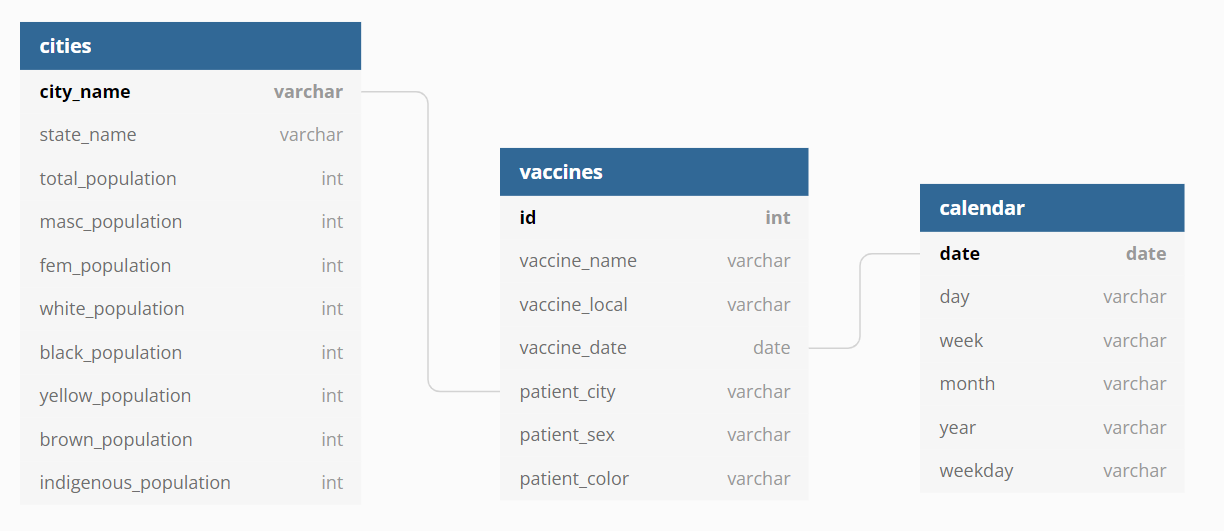

In [22]:
from IPython.display import Image
Image(filename='datamodel.png')

#### 3.2 Mapping Out Data Pipelines
The data was cleaned previously, now we will insert into parquet files and make a join to enrich the vaccine data with more information.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model

In [23]:
#output folder to save parquest files
output_folder = "output/"

def save_to_parquet(dataframe, parquet_file_path, partition_columns, mode="overwrite"):
    dataframe.write.parquet(parquet_file_path, partitionBy=partition_columns, mode=mode)

In [24]:
def create_calendar_table(df_cleaned_vac):
    # Make the calendar table, getting the date and breaking down in more specific columns
    df_calendar = df_cleaned_vac.select(col('data_aplicacao')).withColumn('date', df_cleaned_vac.data_aplicacao.cast(DateType())).distinct()
    df_calendar = df_calendar.withColumn('day', dayofmonth('date'))
    df_calendar = df_calendar.withColumn('week', weekofyear('date'))
    df_calendar = df_calendar.withColumn('month', month('date'))
    df_calendar = df_calendar.withColumn('year', year('date'))
    df_calendar = df_calendar.withColumn('weekday', dayofweek('date'))
    #remove duplicated column
    df_calendar = df_calendar.drop(df_calendar.data_aplicacao)
    return df_calendar

df_calendar = create_calendar_table(df_cleaned_vac)
df_calendar.limit(5).toPandas()

partition_columns = ['year', 'month', 'week']
save_to_parquet(df_calendar, output_folder + "calendar", partition_columns)

In [25]:
# Join vaccines info with city info
df_full = df_cleaned_vac.join(df_cleaned_cities, df_cleaned_vac.paciente_municipio ==  df_cleaned_cities['City'], "inner")

In [26]:
df_full.limit(5).toPandas()

,paciente_codigo_grupo,vacina,vacina_lote,estabelecimento_razao_social,estabelecimento,paciente_cep,estabelecimento_unidade_federativa,sistema_origem,paciente_municipio,paciente_etnia,...,Homens,Mulheres,Branca,Preta,Amarela,Parda,Indígena,Sem declaração,City,State
0,2,Covid-19-Coronavac-Sinovac/Butantan,210013.0,PREFEITURA MUNICIPAL DE CARAUBAS,CENTRO DE SAUDE DE CARAUBAS DR JOAO MARINALDO ...,59700,RN,RN + Vacina,Apodi,Branca,...,17376,17387,15483,902,291,18087,None,None,Apodi,RN
1,2,Vacina Covid-19 - Covishield,NaN,PREFEITURA MUNICIPAL DE APODI,SECRETARIA MUNICIPAL DE SAUDE DE APODI,59700,RN,RN + Vacina,Apodi,Branca,...,17376,17387,15483,902,291,18087,None,None,Apodi,RN
2,9,Covid-19-Coronavac-Sinovac/Butantan,202009011.0,PREFEITURA MUNICIPAL DE APODI,CENTRO DE SAUDE DE APODI,59700,RN,RN + Vacina,Apodi,Branca,...,17376,17387,15483,902,291,18087,None,None,Apodi,RN
3,9,Covid-19-Coronavac-Sinovac/Butantan,202009011.0,PREFEITURA MUNICIPAL DE APODI,CENTRO DE SAUDE DE APODI,59700,RN,RN + Vacina,Apodi,Parda,...,17376,17387,15483,902,291,18087,None,None,Apodi,RN
4,2,Covid-19-Coronavac-Sinovac/Butantan,210013.0,PREFEITURA MUNICIPAL DE APODI,CENTRO DE SAUDE DE APODI,59700,RN,RN + Vacina,Apodi,Branca,...,17376,17387,15483,902,291,18087,None,None,Apodi,RN


In [27]:
df_full.printSchema()

root
 |-- paciente_codigo_grupo: integer (nullable = true)
 |-- vacina: string (nullable = true)
 |-- vacina_lote: integer (nullable = true)
 |-- estabelecimento_razao_social: string (nullable = true)
 |-- estabelecimento: string (nullable = true)
 |-- paciente_cep: integer (nullable = true)
 |-- estabelecimento_unidade_federativa: string (nullable = true)
 |-- sistema_origem: string (nullable = true)
 |-- paciente_municipio: string (nullable = true)
 |-- paciente_etnia: string (nullable = true)
 |-- estabelecimento_municipio: string (nullable = true)
 |-- paciente_idade: string (nullable = true)
 |-- paciente_codigo_subgrupo: integer (nullable = true)
 |-- numero_dose: integer (nullable = true)
 |-- paciente_nacionalidade: string (nullable = true)
 |-- codigo_vacina: integer (nullable = true)
 |-- estabelecimento_codigo_ibge_municipio: integer (nullable = true)
 |-- paciente_uuid: string (nullable = true)
 |-- paciente_grupo: string (nullable = true)
 |-- data_aplicacao: date (nullabl

In [28]:
df_cities = df_full.select(['City', 'State', 'Total', 'Homens', 'Mulheres', 'Branca', 'Preta', 'Amarela', 'Parda', 'Indígena']).distinct()
df_cities.limit(5).toPandas()

,City,State,Total,Homens,Mulheres,Branca,Preta,Amarela,Parda,Indígena
0,Apodi,RN,34763,17376,17387,15483,902,291,18087,NaN
1,Araruama,RJ,112008,54283,57725,49932,15156,453,46272,173.0
2,Assis Brasil,AC,6072,3091,2981,1638,277,140,3486,531.0
3,Benedito Leite,MA,5469,2855,2614,1483,283,10,3691,2.0
4,Boa Esperança do Sul,SP,13645,6875,6770,8217,502,39,4887,NaN


In [29]:
def create_cities_table(df_cities):
    #Rename columns to match datamodel
    df_cities = df_cities.withColumnRenamed("City", "city_name")
    df_cities = df_cities.withColumnRenamed("State", "state_name")
    df_cities = df_cities.withColumnRenamed("Total", "total_population")
    df_cities = df_cities.withColumnRenamed("Homens", "masc_population")
    df_cities = df_cities.withColumnRenamed("Mulheres", "fem_population")
    df_cities = df_cities.withColumnRenamed("Branca", "white_population")
    df_cities = df_cities.withColumnRenamed("Preta", "black_population")
    df_cities = df_cities.withColumnRenamed("Amarela", "yellow_population")
    df_cities = df_cities.withColumnRenamed("Parda", "brown_population")
    df_cities = df_cities.withColumnRenamed("Indígena", "indigenous_population")
    return df_cities

df_cities = create_cities_table(df_cities)
df_cities.limit(5).toPandas()

,city_name,state_name,total_population,masc_population,fem_population,white_population,black_population,yellow_population,brown_population,indigenous_population
0,Apodi,RN,34763,17376,17387,15483,902,291,18087,NaN
1,Araruama,RJ,112008,54283,57725,49932,15156,453,46272,173.0
2,Assis Brasil,AC,6072,3091,2981,1638,277,140,3486,531.0
3,Benedito Leite,MA,5469,2855,2614,1483,283,10,3691,2.0
4,Boa Esperança do Sul,SP,13645,6875,6770,8217,502,39,4887,NaN


In [30]:
#save cities info to parquet 
partition_columns = ['state_name', 'city_name']
save_to_parquet(df_cities, output_folder + "cities", partition_columns)

In [31]:
df_cities.filter(col('State')=='SP').count()

645

In [32]:
#filter vaccine data for São Paulo state as an example (we could consider the entire dataframe here, but as demonstration, we will use only São Paulo related data)
df_vaccines = df_full.filter(col('State') =='SP').select(col('paciente_uuid'), col('vacina'), col('data_aplicacao'), col('estabelecimento'), col('paciente_municipio'), col('paciente_sexo_biologico'), col('paciente_etnia'))
df_vaccines.limit(5).toPandas()

,paciente_uuid,vacina,data_aplicacao,estabelecimento,paciente_municipio,paciente_sexo_biologico,paciente_etnia
0,478973ee-c1c0-5b63-80ed-9ca773a066da,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE II DE BROTAS,Boa Esperança do Sul,M,Branca
1,2858d7d5-7857-5b4e-a12d-9b80fca9c263,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE NOVA ESPERANCA BOA ESPERANCA D...,Boa Esperança do Sul,F,Amarela
2,c3ac7ab9-d08b-55cb-8e56-81cdac8f363a,Covid-19-Coronavac-Sinovac/Butantan,2021-02-08,CENTRO DE SAUDE III BOA ESPERANCA DO SUL,Boa Esperança do Sul,F,Branca
3,8aca8c9c-4bbb-5c2d-b614-3f8d8205abcd,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE NOVA ESPERANCA BOA ESPERANCA D...,Boa Esperança do Sul,F,Branca
4,f0f84435-f601-5b02-b26a-52a71f0df619,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,USF PALMEIRAS BOA ESPERANCA DO SUL,Boa Esperança do Sul,F,Branca


In [33]:
def create_vaccines_table(df_vaccines):
    #Rename columns to match datamodel
    df_vaccines = df_vaccines.withColumnRenamed("paciente_uuid", "id")
    df_vaccines = df_vaccines.withColumnRenamed("vacina", "vaccine_name")
    df_vaccines = df_vaccines.withColumnRenamed("estabelecimento", "vaccine_local")
    df_vaccines = df_vaccines.withColumnRenamed("data_aplicacao", "vaccine_date")
    df_vaccines = df_vaccines.withColumnRenamed("paciente_municipio", "patient_city")
    df_vaccines = df_vaccines.withColumnRenamed("paciente_sexo_biologico", "patient_sex")
    df_vaccines = df_vaccines.withColumnRenamed("paciente_etnia", "patient_color")
    return df_vaccines

df_vaccines = create_vaccines_table(df_vaccines)
df_vaccines.limit(5).toPandas()

,id,vaccine_name,vaccine_date,vaccine_local,patient_city,patient_sex,patient_color
0,478973ee-c1c0-5b63-80ed-9ca773a066da,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE II DE BROTAS,Boa Esperança do Sul,M,Branca
1,2858d7d5-7857-5b4e-a12d-9b80fca9c263,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE NOVA ESPERANCA BOA ESPERANCA D...,Boa Esperança do Sul,F,Amarela
2,c3ac7ab9-d08b-55cb-8e56-81cdac8f363a,Covid-19-Coronavac-Sinovac/Butantan,2021-02-08,CENTRO DE SAUDE III BOA ESPERANCA DO SUL,Boa Esperança do Sul,F,Branca
3,8aca8c9c-4bbb-5c2d-b614-3f8d8205abcd,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,CENTRO DE SAUDE NOVA ESPERANCA BOA ESPERANCA D...,Boa Esperança do Sul,F,Branca
4,f0f84435-f601-5b02-b26a-52a71f0df619,Covid-19-Coronavac-Sinovac/Butantan,2021-02-12,USF PALMEIRAS BOA ESPERANCA DO SUL,Boa Esperança do Sul,F,Branca


In [34]:
#save vaccines info to parquet 
partition_columns = ['vaccine_date', 'patient_city']
save_to_parquet(df_vaccines, output_folder + "vaccines", partition_columns)

#### 4.2 Data Quality Checks

The data quality will check for:
* Integrity of the table schemas
* Verify for empty tables

In [35]:
# Perform quality checks here

def run_quality_checks(table_schemas):
    tables_to_check = table_schemas.keys()
    failed_list=[]
    for table in tables_to_check:
        parquetFile = spark.read.parquet(output_folder + table)

        # Check for the empty parquet file
        if parquetFile.count() <= 0:
            failed_list.append("Table {} is empty.")
        # Compare the schema to check the table integrity
        if len((set(parquetFile.columns) ^ set(table_schemas.get(table))) | (set(parquetFile.columns) ^ set(table_schemas.get(table)))) > 0:
            failed_list.append("Table '{}' has discrepancies in the schema.".format(table))
            
    return failed_list

In [36]:
# Dict with the table name and it columns
table_schemas = {
    'calendar': ['date', 'day', 'weekday', 'year', 'month', 'week'],
    'cities':   ['city_name', 'state_name', 'total_population', 'masc_population', 'fem_population', 'white_population', 
                 'black_population', 'yellow_population', 'brown_population', 'indigenous_population'],
    'vaccines':   ['id', 'vaccine_name', 'vaccine_local', 'vaccine_date', 'patient_city', 'patient_sex', 'patient_color']
}
   
failed_list = run_quality_checks(table_schemas)

if len(failed_list) > 0:
    print("We have some errors: ", failed_list)
else:
    print("Quality Check passed")

Quality Check passed


#### 4.3 Data dictionary

#### Calendar table

| Column  |Description|
|---------|------------|
| date | The date of vaccination (yyyy-mm-dd) |
| day | Day (1-31) |
| week | Week (1-53) |
| month | Month (1-12) |
| year | Year (0-9999) |
| weekday | Weekday (1-7) |

#### Cities table

| Column  |Description|
|---------|------------|
| city_name | City name |
| state_name | State Acronym (2 chars) |
| total_population | Number of total population  |
| masc_population | Number of masculine population |
| fem_population | Number of feminine population |
| white_population | Number of white population |
| black_population | Number of black population |
| yellow_population | Number of yellow population |
| brown_population | Number of brown population |
| indigenous_population | Number of indigenous population|

#### Vaccines table

|Column  |Description|
|---------|------------|
| id | Vaccination ID |
| vaccine_name | Vaccine brand name |
| vaccine_local | Local of vaccination |
| vaccine_date | Date of vaccination |
| patient_city | City in which patient lives |
| patient_sex | Biological sex related to the patient |
| patient_color | Color related to the patient |

#### 4.4 Data analysis

In [55]:
#Reading Parquet files
output_folder = "output/"

vaccines_pqt = spark.read.parquet(output_folder + "vaccines")
vaccines_pqt.createOrReplaceTempView("vaccines")

cities_pqt = spark.read.parquet(output_folder + "cities")
cities_pqt.createOrReplaceTempView("cities")

In [83]:
# Top 10 cities in São Paulo state with the higher % of vaccinated population (Please note that this dataset is from 1 year ago)

most_vaccinated_cities = spark.sql("""
SELECT c.city_name, (count(DISTINCT (v.id))*100/c.total_population) as vac_percent
FROM cities c
JOIN vaccines v ON c.city_name = v.patient_city
WHERE c.state_name = 'SP'
GROUP BY c.city_name, c.total_population
ORDER BY vac_percent DESC LIMIT 10
""")
df_most_vaccinated_cities = most_vaccinated_cities.toPandas()
print (df_most_vaccinated_cities)

       city_name  vac_percent
0      Tabatinga    40.194743
1  São Francisco    33.870390
2       Planalto    32.466950
3    Alto Alegre    28.010726
4      Turmalina    23.154702
5      Vera Cruz    18.302535
6      Arco-Íris    13.454545
7       Eldorado    12.000546
8         Cedral    10.599599
9     Terra Roxa     9.911817


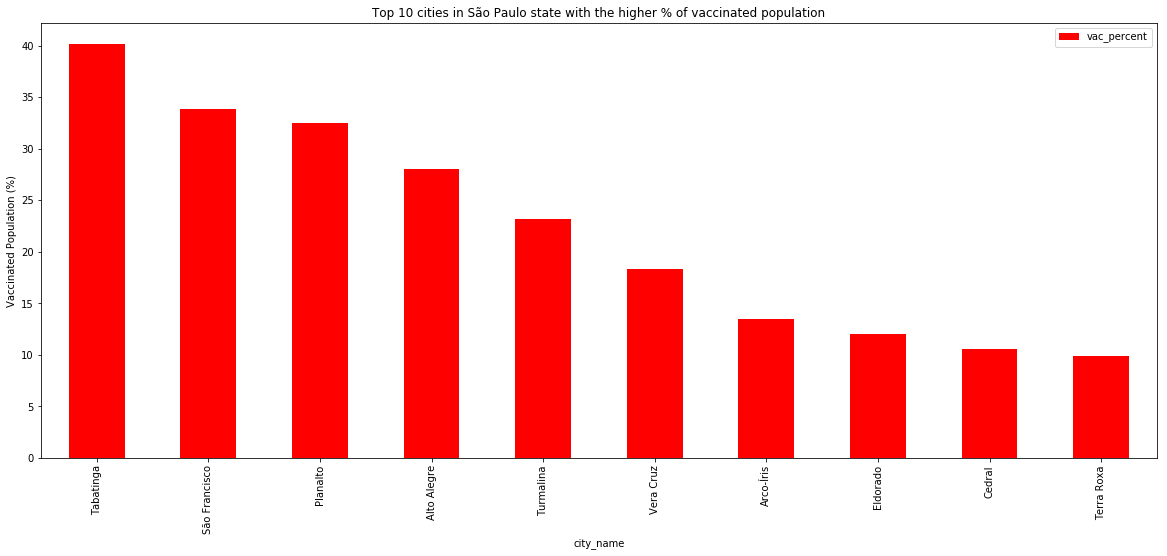

In [86]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

ax.set_ylabel('Vaccinated Population (%)')
ax.set_xlabel('Cities')
ax.set_title('Top 10 cities in São Paulo state with the HIHGER % of vaccinated population')
ax.legend()

df_most_vaccinated_cities.sort_values(['vac_percent'],  ascending = False).plot(x='city_name', y='vac_percent', kind='bar', color='red', ax=ax)

plt.show()

In [87]:
# Top 10 cities with the lower % of vaccinated population

less_vaccinated_cities = spark.sql("""
SELECT c.city_name, (count(DISTINCT (v.id))*100/c.total_population) as vac_percent
FROM cities c
JOIN vaccines v ON c.city_name = v.patient_city
WHERE c.state_name = 'SP'
GROUP BY c.city_name, c.total_population
ORDER BY vac_percent ASC LIMIT 10
""")
df_less_vaccinated_cities = less_vaccinated_cities.toPandas()
print (df_less_vaccinated_cities)

         city_name  vac_percent
0            Iperó     1.621908
1           Ibiúna     1.693416
2  Itaquaquecetuba     1.756845
3          Jandira     1.779517
4      Carapicuíba     1.826107
5          Itapevi     1.885749
6          Guariba     1.902159
7            Potim     1.917822
8  Várzea Paulista     1.940442
9     Araçariguama     1.990632


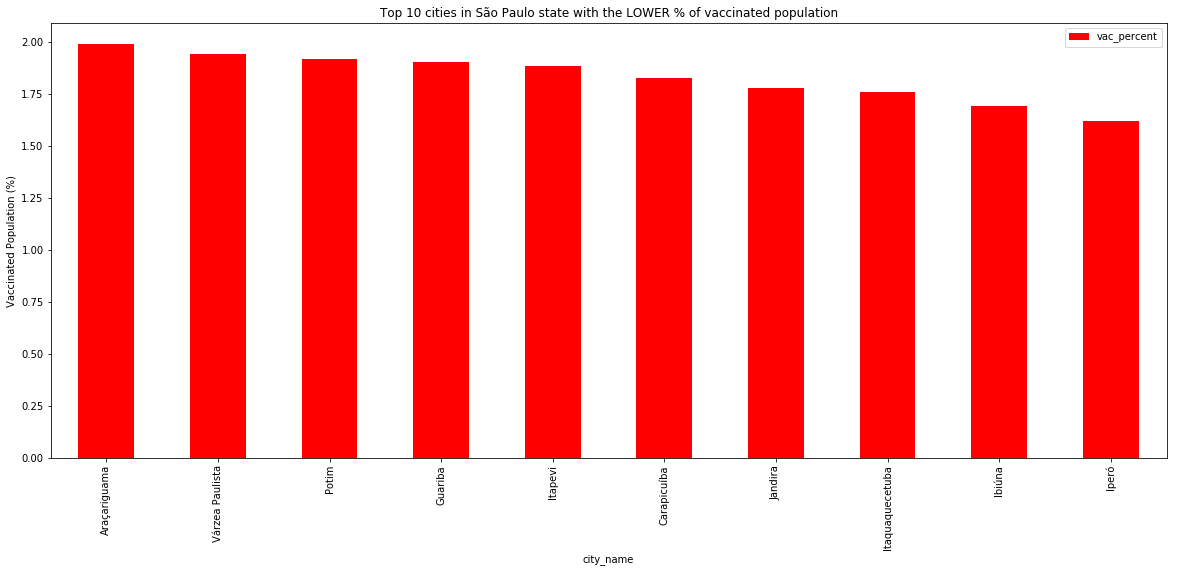

In [88]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

ax.set_ylabel('Vaccinated Population (%)')
ax.set_xlabel('Cities')
ax.set_title('Top 10 cities in São Paulo state with the LOWER % of vaccinated population')
ax.legend()

df_less_vaccinated_cities.sort_values(['vac_percent'],  ascending = False).plot(x='city_name', y='vac_percent', kind='bar', color='red', ax=ax)

plt.show()

In [94]:
# Top vaccine brands used in Tabatinga - We will use São Paulo city as an example since it the biggest city in Brazil
top_vaccine_brands = spark.sql("""
SELECT v.vaccine_name, (count(DISTINCT (v.id)))
FROM cities c
JOIN vaccines v ON c.city_name = v.patient_city
WHERE c.state_name = 'SP' and c.city_name = 'São Paulo'
GROUP BY v.vaccine_name
""")
df_top_vaccine_brands = top_vaccine_brands.toPandas()
print (df_top_vaccine_brands)
# Here it is possible to see that at the moment the dataset was taken, Brazil was only using a few vaccine brands

                                        vaccine_name  count(DISTINCT id)
0                Covid-19-Coronavac-Sinovac/Butantan              307784
1                       Vacina Covid-19 - Covishield              106567
2  Vacina covid-19 - BNT162b2 - BioNTech/Fosun Ph...                   1


In [96]:
# Color division related to 'Covid-19-Coronavac-Sinovac/Butantan' in São Paulo city
color_division_1 = spark.sql("""
SELECT v.patient_color, (count(DISTINCT (v.id))) as vac_count
FROM cities c
JOIN vaccines v ON c.city_name = v.patient_city
WHERE c.state_name = 'SP' and c.city_name = 'São Paulo' and v.vaccine_name = 'Covid-19-Coronavac-Sinovac/Butantan'
GROUP BY v.patient_color
""")

df_color_division_1 = color_division_1.toPandas()
print (df_color_division_1)

  patient_color  vac_count
0      Indígena        589
1          None     189230
2         Preta       7896
3       Amarela      15851
4        Branca      79405
5         Parda      14827


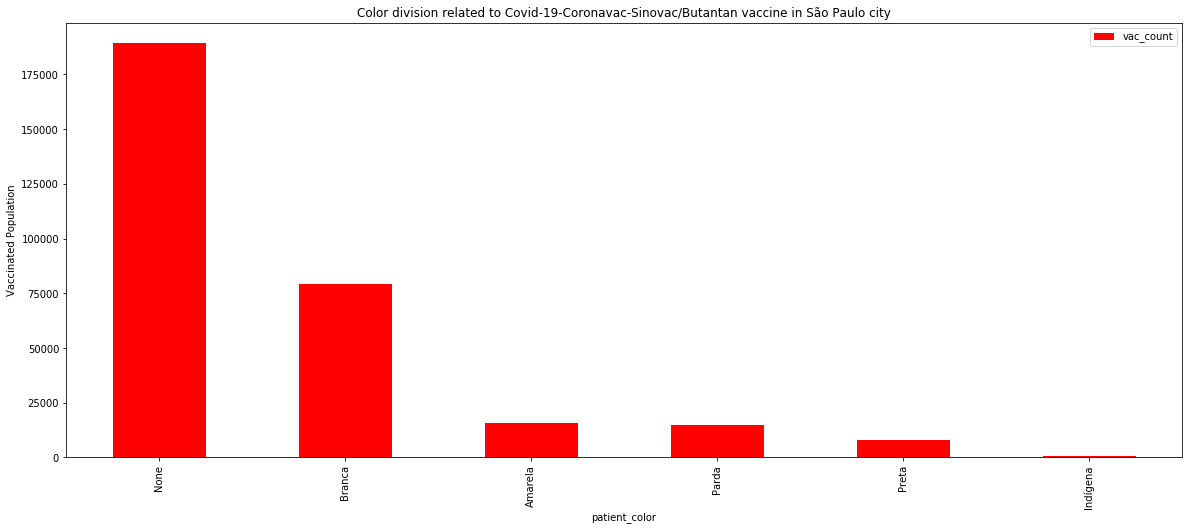

In [99]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

ax.set_ylabel('Vaccinated Population')
ax.set_xlabel('Patient Color')
ax.set_title('Color division related to Covid-19-Coronavac-Sinovac/Butantan vaccine in São Paulo city')
ax.legend()

df_color_division_1.sort_values(['vac_count'],  ascending = False).plot(x='patient_color', y='vac_count', kind='bar', color='red', ax=ax)

plt.show()

In [101]:
# Color division related to 'Vacina Covid-19 - Covishield' in São Paulo city
color_division_2 = spark.sql("""
SELECT v.patient_color, (count(DISTINCT (v.id))) as vac_count
FROM cities c
JOIN vaccines v ON c.city_name = v.patient_city
WHERE c.state_name = 'SP' and c.city_name = 'São Paulo' and v.vaccine_name = 'Vacina Covid-19 - Covishield'
GROUP BY v.patient_color
""")

df_color_division_2 = color_division_2.toPandas()
print (df_color_division_2)

  patient_color  vac_count
0      Indígena         37
1          None      58945
2         Preta       3830
3       Amarela       7596
4        Branca      29158
5         Parda       7001


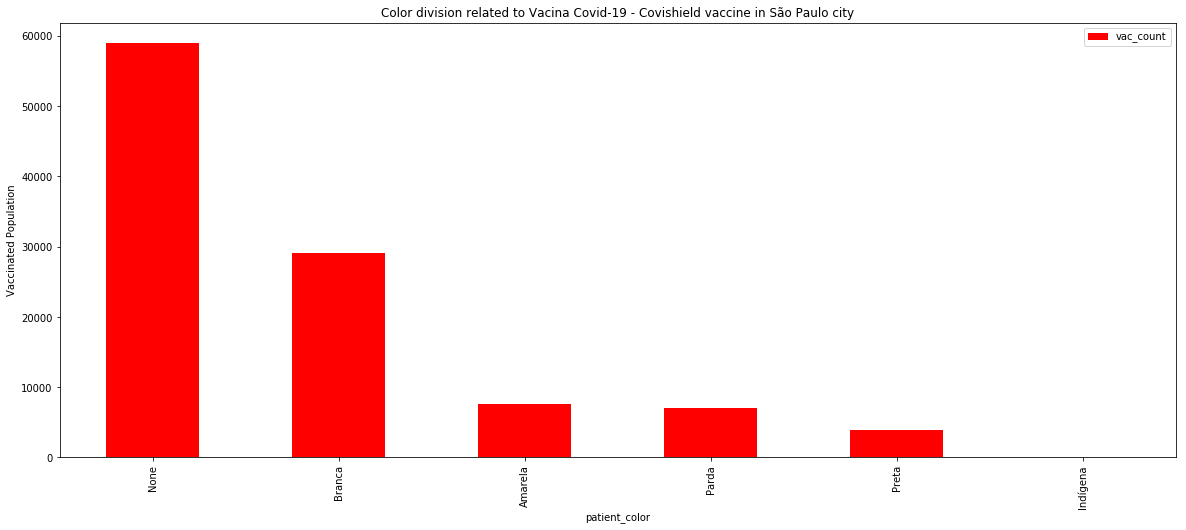

In [102]:
fig = plt.figure(figsize=(20, 8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

ax.set_ylabel('Vaccinated Population')
ax.set_xlabel('Patient Color')
ax.set_title('Color division related to Vacina Covid-19 - Covishield vaccine in São Paulo city')
ax.legend()

df_color_division_2.sort_values(['vac_count'],  ascending = False).plot(x='patient_color', y='vac_count', kind='bar', color='red', ax=ax)

plt.show()

In [106]:
# For comparison, let's check São Paulo color division based on total population
sp_color_division = spark.sql("""
SELECT *
FROM cities c
WHERE c.state_name = 'SP' and c.city_name = 'São Paulo'
""")

df_sp_color_division = sp_color_division.toPandas()
display(df_sp_color_division)

,total_population,masc_population,fem_population,white_population,black_population,yellow_population,brown_population,indigenous_population,state_name,city_name
0,11253503,5328632,5924871,6823004,717215,250146,3447290,12959,SP,São Paulo


This analysis was just an example but many other can be performed as well:
 * Other cities and states could be considered
 * We could filter the vaccination count difference by sex. 
 * We could also compare the most and less vaccinate cities for a specific color. 

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    * Answer: PySpark was used because we can increase the amount of data and it will handle well it's very easy to make debug and tests things.

* Propose how often the data should be updated and why.
    * Answer: The data should by updated yearly in vaccination dataset case (it was gathered 1 year ago).

* Write a description of how you would approach the problem differently under the following scenarios:
 
    * The data was increased by 100x.
        * Answer: We can scale up the Spark cluster, also we can make some improvements in the way we make the join to optimize that. Alternatively, we can use the EMR, once that tool can access the data in various sources like S3, HDFS, Redshift and others.
 
    * The data populates a dashboard that must be updated on a daily basis by 7am every day.
        * Answer: Once all the vaccine data is collected, we can do it using the Airflow as a task orchestrator and PySpark, Redshift or even EMR to transform and process all the data or even just the last day data.

    * The database needed to be accessed by 100+ people.
        * Answer: We can use the s3 folder or even a Redshift cluster to save the data. Also we can better agregate the data case we face issues in the performance or network and use a Apache Cassandra (NoSQL) to save that agregatted data to a faster reading.